# Minimum Wage Simulation -- Estimator Comparisons



In [1]:
import os
# set wd to Users/boyuchen/Documents/UBC/RA/minimum_wage
os.chdir('/Users/boyuchen/Documents/UBC/RA/minimum_wage')

from codes.simulation_functions import *

**Purpose**: demonstrate whether the three methods worked as expected.

**TL;DR:** 

1. Scenarios of choice: two truncated scenarios with no bunching and spillovers; then one with bunching and one with spillover.
2. Cengiz et al(2019) did a good job in not producing spurious spillover effect.
3. Percentile method gives the spurious "spillover effect" in S1 to S3.
4. My hazard estimates results have significant effect on bins above the minimum wage bin, which is not what I expected. 

In [2]:
log_wages = generate_log_wages(1_000_000)  

# run df_grouped for four proability scenarios:
# real_m_pre, real_m_post, P_o, P_b, P_s
scenarios = {
    'S1': (10, 12, 0.8, 0, 0),
    'S2': (10, 12, 0.5, 0, 0),
    'S3': (10, 12, 0.5, 0.3, 0),
    'S4': (10, 12, 0.5, 0, 0.3),
}

# scenarios = {
#     'S1': (10.05, 12.05, 0.3, 0.5, 0),
#     'S2': (10.05, 12.05, 0.3, 0, 0.5),
#     'S3': (13.05, 15.05, 0.3, 0.5, 0),
#     'S4': (13.05, 15.05, 0.3, 0, 0.5),
# }

## Cengiz et al.(2019) Method

I replicated and simplified Cengiz method. In S1 an S2, there are strong employment impact on bins right below the minimum wage bin. In S3, the method captures only bunching. In S4, the model captures the spillover effect. Overall the method produces good results that reflect the underlying model. 

*Notes: Since we use a two-period model, the old minimum wage  yields a visible trend near the level, which is not visible in their results since it has many period and states and the effect of "old" minimum wage is washed out.*

In [3]:
# Function to apply Cengiz method for employment changes and wage effects
def cengiz_method(log_wages, scenario):
    real_m_pre, real_m_post, P_o, P_b, P_s = scenario
    m_pre = np.log(real_m_pre)
    m_post = np.log(real_m_post)

    df_pre = impose_minimum_wage(log_wages, m_pre, P_o, P_b, P_s)
    df_post = impose_minimum_wage(log_wages, m_post, P_o, P_b, P_s)

    def to_real_scale(log_wages):
        return np.exp(log_wages)

    df_pre['real_wages'] = to_real_scale(df_pre['adjusted_log_wages'])
    df_post['real_wages'] = to_real_scale(df_post['adjusted_log_wages'])

    # Define the 75 percentile of the pre-wage distribution (Wbar)
    Wbar = df_pre['real_wages'].quantile(0.75)

    bin_width = 0.25

    # Assign bins for pre and post data, excluding unemployed
    bins_pre = np.arange(0, Wbar + bin_width, bin_width)
    bins_post = np.arange(0, Wbar + bin_width, bin_width)

    df_pre['wage_bin'] = pd.cut(df_pre['real_wages'], bins=bins_pre, right=False)
    df_post['wage_bin'] = pd.cut(df_post['real_wages'], bins=bins_post, right=False)

    # Calculate the pre-period average wage of workers below the initial minimum wage
    affected_pre = df_pre[df_pre['original_log_wages'] < m_pre]
    # affected_post = df_post[df_post['original_log_wages'] < m_pre]

    average_affected_wage_pre = affected_pre['real_wages'].mean()
    affected_wage_bill_pre = affected_pre['real_wages'].sum()
    total_wage_bill_pre = df_pre['real_wages'].sum()
    total_wage_bill_post = df_post['real_wages'].sum()
    Δtotal_wage_bill = total_wage_bill_post - total_wage_bill_pre
    
    # Count the number of workers in each wage bin, excluding unemployed
    pre_counts = df_pre['wage_bin'].value_counts().sort_index()
    post_counts = df_post['wage_bin'].value_counts().sort_index()

    # count the total number of affected worker in the pre-period using affected_pre
    total_affected_pre = affected_pre.shape[0]

    pre_counts = pre_counts.reindex_like(post_counts).fillna(0)
    post_counts = post_counts.reindex_like(pre_counts).fillna(0)

    # Create a boolean mask for intervals where the left edge is greater than or equal to m_post
    mask_post = np.array([interval.left >= np.exp(m_post).round(3) for interval in post_counts.index])
    mask_pre = np.array([interval.left >= np.exp(m_post).round(3) for interval in pre_counts.index])

    # Calculate excess and missing jobs, only considering bins below Wbar
    Δa = post_counts[mask_post].sum() - pre_counts[mask_pre].sum()
    Δb = post_counts[~mask_post].sum() - pre_counts[~mask_pre].sum()
    Δemp = Δa + Δb

    total_employed_pre = pre_counts.sum()

    Δm = np.exp(m_post) - np.exp(m_pre)
    employment_elasticity = (Δemp / total_employed_pre) / (Δm / np.exp(m_pre))

    # change in total employment over the "affected workers" in the pre-period
    affected_employment_change = Δemp / total_affected_pre

    # change in wage bills of affected workers is the pre-period affected wage bill + the total change in wage bill of all workers
    affected_new_wage_bill = affected_wage_bill_pre + Δtotal_wage_bill
    affected_employment_post = total_affected_pre + Δemp

    # calculate percentage change in the average wage of affected workers
    new_average_wage_affected = affected_new_wage_bill / affected_employment_post

    # calculate percentage change in the average wage of affected workers
    percentage_change_average_wage_affected = (new_average_wage_affected - average_affected_wage_pre) / average_affected_wage_pre

    # calculate own_elasticity 
    own_wage_elasticity = affected_employment_change / percentage_change_average_wage_affected

    return {
        'employment_elasticity': employment_elasticity,
        'own_wage_elasticity': own_wage_elasticity,
        'percentage_change_affected_employment': affected_employment_change,
        'percentage_change_average_wage_affected': percentage_change_average_wage_affected,
        'Δa': Δa,
        'Δb': Δb,
        'bins_pre': pre_counts.index.tolist(),
        'pre_counts': pre_counts,
        'post_counts': post_counts
    }



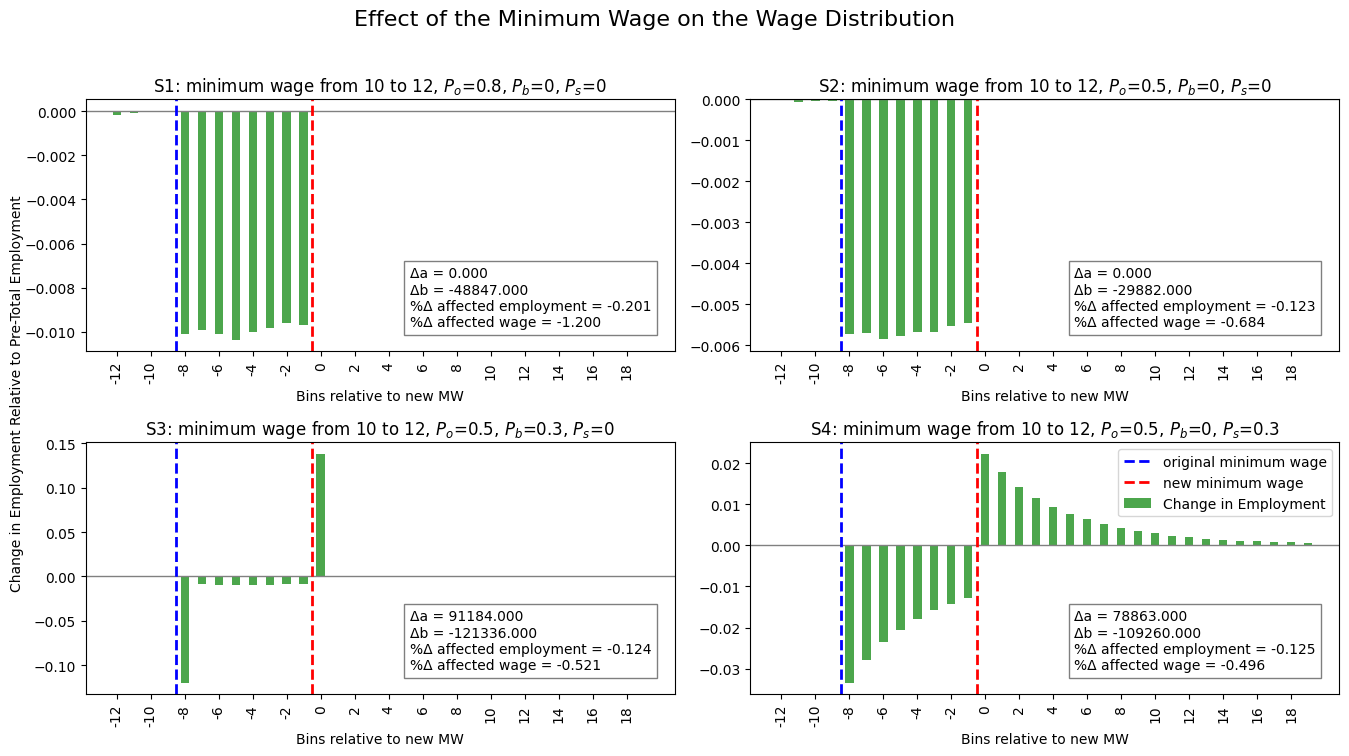

In [4]:
def plot_changes_in_employment(result, scenario_name, scenario):
    real_m_pre, real_m_post, P_o, P_b, P_s = scenario
    pre_counts = result['pre_counts']
    post_counts = result['post_counts']
    bins_pre = result['bins_pre']
    Δa = result['Δa']
    Δb = result['Δb']
    percentage_change_affected_employment = result['percentage_change_affected_employment']
    percentage_change_average_wage_affected = result['percentage_change_average_wage_affected']

    # Calculate the changes in employment
    employment_changes = post_counts - pre_counts

    # Calculate the total pre-employment
    total_pre_employment = pre_counts.sum()

    # Calculate relative changes to pre-total employment
    relative_employment_changes = employment_changes / total_pre_employment

    # Extract intervals for display
    intervals = [interval.left for interval in bins_pre]

    # Calculate bins relative to real_m_post
    bins_relative_to_post = [round((interval - real_m_post) / (bins_pre[1].left - bins_pre[0].left)) for interval in intervals]

    # Find the positions for m_pre and m_post
    m_pre_pos = next(i for i, interval in enumerate(intervals) if interval >= real_m_pre)
    m_post_pos = next(i for i, interval in enumerate(intervals) if interval >= real_m_post)

    # Select 10 bins below real_m_pre and 30 bins above real_m_post
    start_idx = max(0, m_pre_pos - 4)
    end_idx = min(len(intervals), m_post_pos + 20)

    bins_relative_to_post = bins_relative_to_post[start_idx:end_idx]
    relative_employment_changes = relative_employment_changes[start_idx:end_idx]

    bar_width = 0.5
    index = np.arange(len(bins_relative_to_post))

    ax.bar(index, relative_employment_changes, bar_width, alpha=0.7, color='green', label='Change in Employment')

    ax.set_xlabel('Bins relative to new MW')
    # ax.set_ylabel('% Change in Employment Relative to Pre-Total Employment')
    ax.set_title(f'{scenario_name}: minimum wage from {real_m_pre} to {real_m_post}, $P_o$={P_o}, $P_b$={P_b}, $P_s$={P_s}')
    ax.set_xticks(index[::2])
    ax.set_xticklabels(bins_relative_to_post[::2], rotation=90)

    # Add grey line at y=0
    ax.axhline(y=0, color='grey', linestyle='-', linewidth=1)

    # Adjust positions for m_pre and m_post lines to match the selected bins
    m_pre_pos_adj = m_pre_pos - start_idx
    m_post_pos_adj = m_post_pos - start_idx

    # Add m_pre and m_post lines
    ax.axvline(m_pre_pos_adj - 0.5, color='blue', linestyle='--', linewidth=2, label='original minimum wage')
    ax.axvline(m_post_pos_adj - 0.5, color='red', linestyle='--', linewidth=2, label='new minimum wage')

    # Add parameters to the lower left
    ax.text(0.55, 0.1,
             f'Δa = {Δa:.3f}\nΔb = {Δb:.3f}\n%Δ affected employment = {percentage_change_affected_employment:.3f}\n%Δ affected wage = {percentage_change_average_wage_affected:.3f}',
             bbox=dict(facecolor='white', alpha=0.5), transform=ax.transAxes)

    # ax.legend()
    plt.tight_layout()

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 8))

# Generate and plot results for each scenario
for ax, (scenario_name, scenario) in zip(axs.flatten(), scenarios.items()):
    result = cengiz_method(log_wages, scenario)
    plot_changes_in_employment(result, scenario_name, scenario)

# Set common ylabel
fig.text(0.04, 0.5, 'Change in Employment Relative to Pre-Total Employment', va='center', rotation='vertical')
plt.suptitle('Effect of the Minimum Wage on the Wage Distribution', fontsize=16)
# only show legend for panel 3
axs[1, 1].legend()

# Adjust layout
plt.tight_layout(rect=[0.04, 0.04, 1, 0.96])
plt.show()


## Naive percentile OLS


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

def calculate_percentiles(log_wages, scenario):
    real_m_pre, real_m_post, P_o, P_b, P_s = scenario
    m_pre = np.log(real_m_pre)
    m_post = np.log(real_m_post)
    df_pre = impose_minimum_wage(log_wages, m_pre, P_o, P_b, P_s)
    df_post = impose_minimum_wage(log_wages, m_post, P_o, P_b, P_s)


    def to_real_scale(log_wages):
        return np.exp(log_wages)

    df_pre['real_wages'] = to_real_scale(df_pre['adjusted_log_wages'])
    df_post['real_wages'] = to_real_scale(df_post['adjusted_log_wages'])

    percentiles = np.arange(0, 85, 5)

    pre_percentiles = np.percentile(df_pre['real_wages'].dropna(), percentiles)
    post_percentiles = np.percentile(df_post['real_wages'].dropna(), percentiles)
    
    # Calculate 95th percentile
    p95_pre = np.percentile(df_pre['real_wages'].dropna(), 95)
    p95_post = np.percentile(df_post['real_wages'].dropna(), 95)
    x_limit = max(p95_pre, p95_post)

    return pre_percentiles, post_percentiles, df_pre['real_wages'].dropna(), df_post['real_wages'].dropna(), x_limit


The figure shows the relative changes in precentiles as the minimum wage changes. As expected, all percentiles "inflated" as some more people got unemployed. We got bad results as expected.

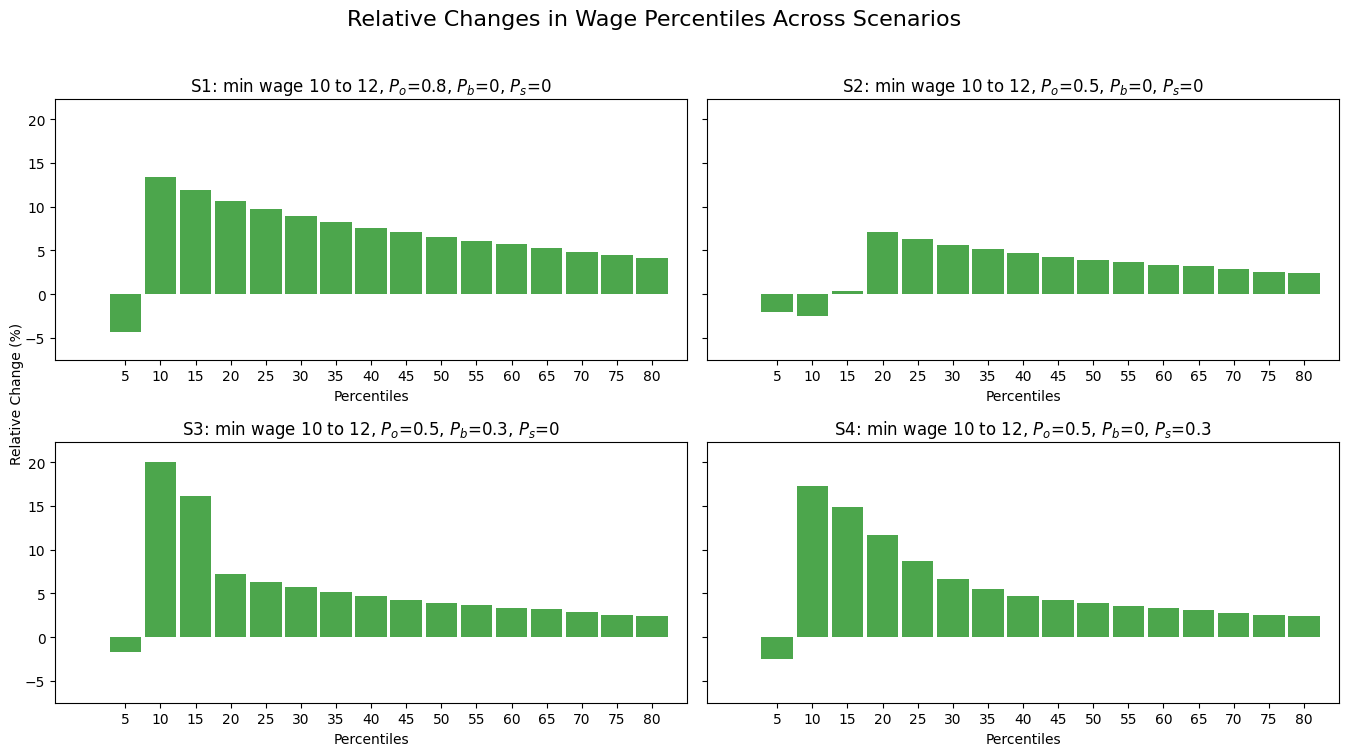

In [6]:
# Define the figure and axes for subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharey=True)

# Flatten axes for easy iteration
axes = axes.flatten()

# Generate and plot results for each scenario
for i, (scenario_name, params) in enumerate(scenarios.items()):
    pre_percentiles, post_percentiles, _, _, x_limit = calculate_percentiles(log_wages, params)
    relative_changes = (post_percentiles - pre_percentiles) / pre_percentiles * 100

    ax = axes[i]
    percentiles = np.arange(5, 85, 5)


    ax.bar(percentiles, relative_changes[1:], width=4.5, alpha=0.7, color='green')
    ax.set_xlabel('Percentiles')
    # ax.set_ylabel('Relative Change (%)')
    ax.set_title(f'{scenario_name}: min wage {params[0]} to {params[1]}, $P_o$={params[2]}, $P_b$={params[3]}, $P_s$={params[4]}')
    ax.set_xticks(percentiles)
    ax.set_xlim([-5, 85])
    ax.set_ylim([min(relative_changes[1:]) - 5, max(relative_changes[1:]) + 5])

# Set the main title
plt.suptitle('Relative Changes in Wage Percentiles Across Scenarios', fontsize=16)
fig.text(0.04, 0.5, 'Relative Change (%)', va='center', rotation='vertical')

# Adjust layout
plt.tight_layout(rect=[0.04, 0.04, 1, 0.96])
plt.show()


## Hazard Estimator


I first prepare the data and variables following the definition that Thomas gave me. I change `min6b` to `min610b` as it is what you have in your paper. This shouldn't affect the main result of this method.

In [7]:
def prepare_hazard_var(log_wages, real_m_pre, real_m_post, P_o=0.2, P_b=0, P_s=0.5):
    m_pre = np.log(real_m_pre)
    m_post = np.log(real_m_post)

    # Assuming impose_minimum_wage function is defined elsewhere
    df_pre = impose_minimum_wage(log_wages, m_pre, P_o, P_b, P_s)
    df_post = impose_minimum_wage(log_wages, m_post, P_o, P_b, P_s)

    def to_real_scale(log_wages):
        return np.exp(log_wages)

    df_pre['real_wages'] = to_real_scale(df_pre['adjusted_log_wages'])
    df_post['real_wages'] = to_real_scale(df_post['adjusted_log_wages'])

    # drop the unemployed
    df_pre = df_pre.dropna(subset=['real_wages'])
    df_post = df_post.dropna(subset=['real_wages'])

    # Simplify bins
    bins = [0] + list(np.arange(4, 20, 0.1)) + [20, np.inf]

    def create_min_dummies(df, real_m):
        # Create bins and labels
        df['wagcat'] = pd.cut(df['real_wages'], bins=bins, labels=False, duplicates='drop')
        # Change wagcat to be integer or NaN
        df['wagcat'] = df['wagcat'].astype('Int64')

        # Find the bin number containing the minimum wage
        m_bin = pd.cut([real_m], bins=bins, labels=False, duplicates='drop')[0]

        # Aggregate data by bin
        df_grouped = df.groupby('wagcat').size().reset_index(name='fweight')
        max_bin = df_grouped['wagcat'].max()
        all_bins = pd.DataFrame({'wagcat': range(max_bin + 1)})
        df_grouped = pd.merge(all_bins, df_grouped, on='wagcat', how='left').fillna(0)

        # Create min and min* variables
        df_grouped['min'] = np.where(df_grouped['wagcat'] == m_bin, 1, 0)
        df_grouped['min610b'] = np.where((df_grouped['wagcat'] >= m_bin - 10) & (df_grouped['wagcat'] <= m_bin - 6), 1, 0)
        df_grouped['min35b'] = np.where((df_grouped['wagcat'] >= m_bin - 5) & (df_grouped['wagcat'] <= m_bin - 3), 1, 0)
        df_grouped['min12b'] = np.where((df_grouped['wagcat'] >= m_bin - 2) & (df_grouped['wagcat'] <= m_bin - 1), 1, 0)
        df_grouped['min12a'] = np.where((df_grouped['wagcat'] >= m_bin + 1) & (df_grouped['wagcat'] <= m_bin + 2), 1, 0)
        df_grouped['min35a'] = np.where((df_grouped['wagcat'] >= m_bin + 3) & (df_grouped['wagcat'] <= m_bin + 5), 1, 0)
        df_grouped['min610a'] = np.where((df_grouped['wagcat'] >= m_bin + 6) & (df_grouped['wagcat'] <= m_bin + 10), 1, 0)
        df_grouped['min1115a'] = np.where((df_grouped['wagcat'] >= m_bin + 11) & (df_grouped['wagcat'] <= m_bin + 15), 1, 0)
        df_grouped['min1620a'] = np.where((df_grouped['wagcat'] >= m_bin + 16) & (df_grouped['wagcat'] <= m_bin + 20), 1, 0)

        # Create bin* dummies
        bin_dummies = pd.get_dummies(df_grouped['wagcat'], prefix='bin')
        df_grouped = pd.concat([df_grouped, bin_dummies], axis=1)
        
        return df_grouped

    # Create min dummies and group by bin-period for both pre and post data
    df_grouped_pre = create_min_dummies(df_pre, real_m_pre)
    df_grouped_pre['period'] = 'pre'

    df_grouped_post = create_min_dummies(df_post, real_m_post)
    df_grouped_post['period'] = 'post'

    # Combine pre and post data
    df_grouped = pd.concat([df_grouped_pre, df_grouped_post])

    # Calculate remain: cumulative sum of fweight in descending order of bins
    df_grouped = df_grouped.sort_values(by=['period', 'wagcat'], ascending=[True, False])
    df_grouped['remain'] = df_grouped.groupby('period')['fweight'].cumsum()

    # assert that by group, remain - remain.shift(1) == fweight
    df_grouped = df_grouped.sort_values(by=['period', 'wagcat'])

    # # group by period: df_grouped['remain_diff'] = df_grouped['remain'].diff()
    df_grouped['remain_diff'] = df_grouped.groupby('period')['remain'].diff()
    df_grouped['lag_fweight'] = df_grouped.groupby('period')['fweight'].shift(1)

    # check if df_grouped[(df_grouped['lag_fweight'] + df_grouped['remain_diff'] == 0) | df_grouped['remain_diff'].isna()].shape[0] == df_grouped.shape[0]
    assert (df_grouped[(df_grouped['lag_fweight'] + df_grouped['remain_diff'] == 0) | df_grouped['remain_diff'].isna()].shape[0] == df_grouped.shape[0]), "Sanity check failed: remain - remain.shift(1) != fweight for some rows"


    # check fweight > 0 for all rows
    assert (df_grouped['fweight'] > 0).all(), "Sanity check failed: fweight <= 0 for some rows"

    # generate ln(-ln(1 - h(y))) as cloglog_hazard
    df_grouped['cloglog_hazard'] = np.log(-np.log(1 - df_grouped['fweight'] / df_grouped['remain']))

    # check cloglog_hazard is not NaN if wagcat is not 161
    assert df_grouped[df_grouped['wagcat'] != 161]['cloglog_hazard'].notna().all(), "Sanity check failed: cloglog_hazard is NaN for some rows where wagcat != 161"
    #drop wagcat == 161
    df_grouped = df_grouped[df_grouped['wagcat'] != 161]

    # Sanity check 1: sum of min* variables must be 0 or 1
    min_vars = ['min','min610b', 'min35b', 'min12b', 'min12a', 'min35a', 'min610a', 'min1115a', 'min1620a']
    df_grouped['min_sum'] = df_grouped[min_vars].sum(axis=1)
    assert df_grouped['min_sum'].isin([0, 1]).all(), "Sanity check failed: sum of min* variables is not 0 or 1 for some rows."

    # Sanity check 2: sum of bin* variables must be 1
    bin_vars = [col for col in df_grouped.columns if col.startswith('bin')]
    df_grouped['bin_sum'] = df_grouped[bin_vars].sum(axis=1)
    assert (df_grouped['bin_sum'] == 1).all(), "Sanity check failed: sum of bin* variables is not 1 for some rows."

    # drop bin_sum and min_sum columns
    df_grouped = df_grouped.drop(columns=['bin_sum', 'min_sum', 'lag_fweight', 'remain_diff'])
    
    return df_grouped


Create data for four scenarios.

In [8]:
# loop through the scenarios
for scenario, params in scenarios.items():
    real_m_pre, real_m_post, P_o, P_b, P_s = params
    df_grouped = prepare_hazard_var(log_wages, real_m_pre, real_m_post, P_o, P_b, P_s)
    print(f"Scenario: {scenario}")
    # print #rows fweight ==0
    print(df_grouped[df_grouped['fweight']==0].shape[0])
    df_grouped.to_stata(f'data/df_grouped_{scenario}.dta')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Scenario: S1
0
Scenario: S2
0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Scenario: S3
0
Scenario: S4
0


Call STATA and run do.file.

In [9]:
# %pip install stata_setup
import stata_setup
stata_setup.config("/Applications/Stata/", "se")


  ___  ____  ____  ____  ____ ®
 /__    /   ____/   /   ____/      18.0
___/   /   /___/   /   /___/       SE—Standard Edition

 Statistics and Data Science       Copyright 1985-2023 StataCorp LLC
                                   StataCorp
                                   4905 Lakeway Drive
                                   College Station, Texas 77845 USA
                                   800-STATA-PC        https://www.stata.com
                                   979-696-4600        stata@stata.com

Stata license: Unlimited-user network, expiring 19 Aug 2024
Serial number: 401809301518
  Licensed to: 陳柏宇
               UBC

Notes:
      1. Unicode is supported; see help unicode_advice.
      2. Maximum number of variables is set to 5,000 but can be increased;
          see help set_maxvar.


In [10]:
%%stata
# execute the following do.file
do "codes/hazard simulation.do"


. # execute the following do.file
Unknown #command
. do "codes/hazard simulation.do"

. cd "/Users/boyuchen/Documents/UBC/RA/minimum_wage"
/Users/boyuchen/Documents/UBC/RA/minimum_wage

. 
. * Clear the existing Excel file or create a new one
. putexcel set tables/glm_coefficients.xlsx, replace


### Notes

- As shown in both the regression results above and figures below, we observed significant positive coefficient in the bins above the minimum wage, which is confusing since there shouldn't be any spillover effect in S1 to S3. 

- I'm thinking if it has anything to do with the "binomial" assumption. Does the distribution assumption impose `fweight` or `fweight`/`remain` to follow a bell shape, or it means something else? If my guess is correct, since the distribution of S1 and S2 are truncated bell shape, to match the bell shape of binomial we got negative coefficients in bins below minimum wage and positive coefficients for bins above, even for `min1620a`. 

- Does the issue only happen in my simulation context? How does the full model avoid this issue with real world data (many period and states.)


In [ ]:
# Define the x-axis ranges for the variables
x_ranges = {
    'min': (0, .1),
    'min610b': (-1.0, -.5),
    'min35b': (-.5, -.2),
    'min12b': (-.2, .0),
    'min12a': (.1, .3),
    'min35a': (.3, .6),
    'min610a': (.6, 1.1),
    'min1115a': (1.1, 1.6),
    'min1620a': (1.6, 2.0)
}

In [ ]:
# Load the Excel file
file_path = 'tables/glm_coefficients.xlsx'

# Function to format the data
def format_data(file_path, scenario):
    df = pd.read_excel(file_path, sheet_name=scenario, header=None)
    variables = df.iloc[1, 1:].values
    coefficients = df.iloc[2, 1:].values
    se = df.iloc[3, 1:].values
    data = pd.DataFrame({
        'Variable': variables,
        'Coefficient': coefficients,
        'SE': se,
        'Scenario': scenario
    })

    # only keep columns where variable start with "min"
    data = data[data['Variable'].str.startswith('min')==True]

    return data

all_data = pd.concat([format_data(file_path, scenario) for scenario in scenarios.keys() ])

# Filter the data for the variables of interest
filtered_data = all_data[all_data['Variable'].isin(x_ranges.keys())]


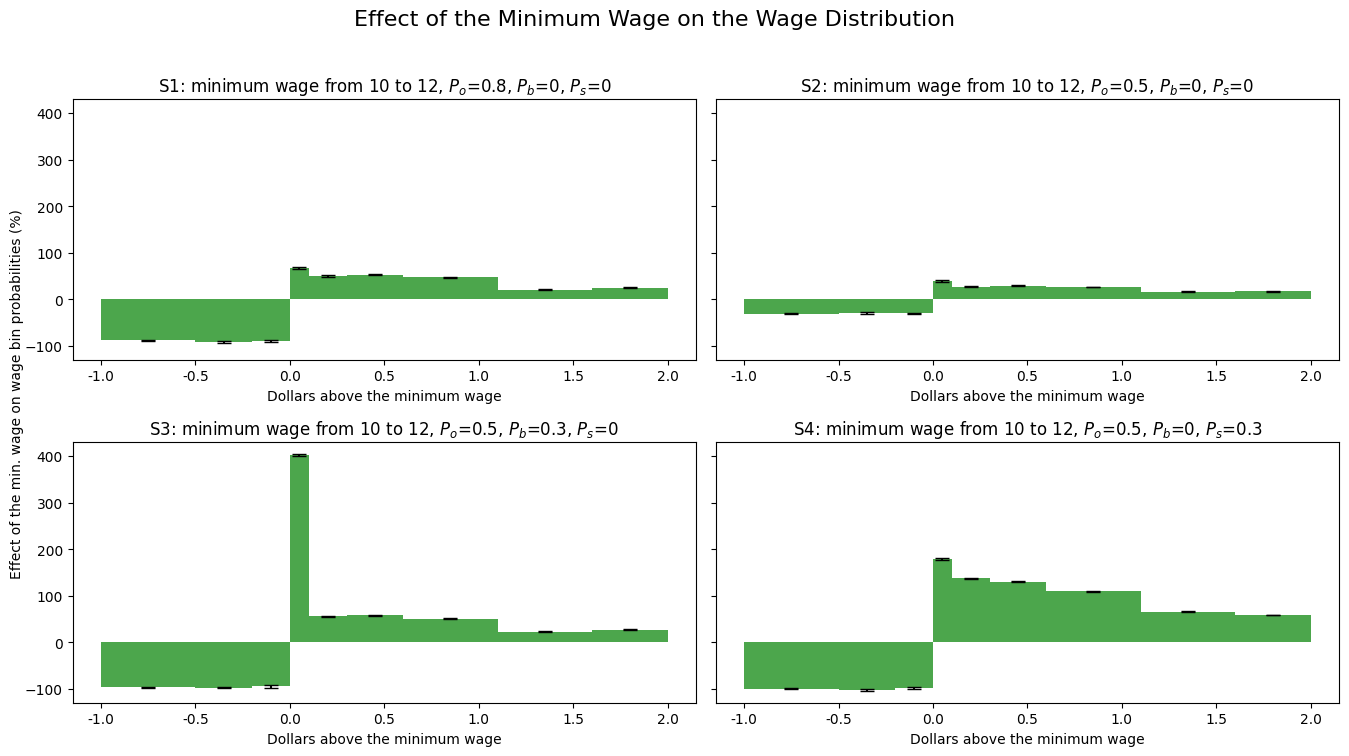

In [ ]:
x_values = []
x_labels = []
widths = []
for var in filtered_data['Variable']:
    if var in x_ranges:
        range_start, range_end = x_ranges[var]
        x_values.append(np.mean([range_start, range_end]) * 10)  # Convert to dollar
        x_labels.append(f"{range_start} to {range_end}")
        widths.append((range_end - range_start) * 10)  # Convert to dollar

# Define the figure and axes for subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharey=True)

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot each scenario in a separate subplot
for i, scenario in enumerate(scenarios):
    real_m_pre, real_m_post, P_o, P_b, P_s = scenarios[scenario]
    scenario_data = filtered_data[filtered_data['Scenario'] == scenario]
    x_scenario_values = [np.mean([x_ranges[var][0], x_ranges[var][1]]) for var in scenario_data['Variable']]  # Convert to percentage
    y_values = scenario_data['Coefficient'] * 100  # Convert to percentage
    y_err = scenario_data['SE'] * 100  # Convert to percentage
    scenario_widths = [(x_ranges[var][1] - x_ranges[var][0]) for var in scenario_data['Variable']]  # Convert to percentage
    
    # Plot the data
    axes[i].bar(x_scenario_values, y_values, width=scenario_widths, yerr=y_err, capsize=5, label=scenario, color = 'green', alpha = 0.7)
    axes[i].set_xlabel('Dollars above the minimum wage')
    axes[i].set_title(f'{scenario}: minimum wage from {real_m_pre} to {real_m_post}, $P_o$={P_o}, $P_b$={P_b}, $P_s$={P_s}')
    # set ylim
    # axes[i].set_ylim(-400, 400)
    # Set x-ticks with a break of 5 bins (0.5 dollars)
    axes[i].set_xticks(np.arange(-1.0, 2.1, .5))
    axes[i].set_xticklabels(np.arange(-1.0, 2.1, 0.5))

# Set common ylabel
fig.text(0.04, 0.5, 'Effect of the min. wage on wage bin probabilities (%)', va='center', rotation='vertical')

# Set the main title
plt.suptitle('Effect of the Minimum Wage on the Wage Distribution (GLM)', fontsize=16)

# Adjust layout
plt.tight_layout(rect=[0.04, 0.04, 1, 0.96])
plt.show()


In [ ]:
# Load the Excel file
file_path = 'tables/ols_coefficients.xlsx'

# Function to format the data
def format_data(file_path, scenario):
    df = pd.read_excel(file_path, sheet_name=scenario, header=None)
    variables = df.iloc[1, 1:].values
    coefficients = df.iloc[2, 1:].values
    se = df.iloc[3, 1:].values
    data = pd.DataFrame({
        'Variable': variables,
        'Coefficient': coefficients,
        'SE': se,
        'Scenario': scenario
    })

    # only keep columns where variable start with "min"
    data = data[data['Variable'].str.startswith('min')==True]

    return data

all_data = pd.concat([format_data(file_path, scenario) for scenario in scenarios.keys() ])

# Filter the data for the variables of interest
filtered_data = all_data[all_data['Variable'].isin(x_ranges.keys())]


Tried OLS and got the same coefficients. The SE from OLS are unadjusted.

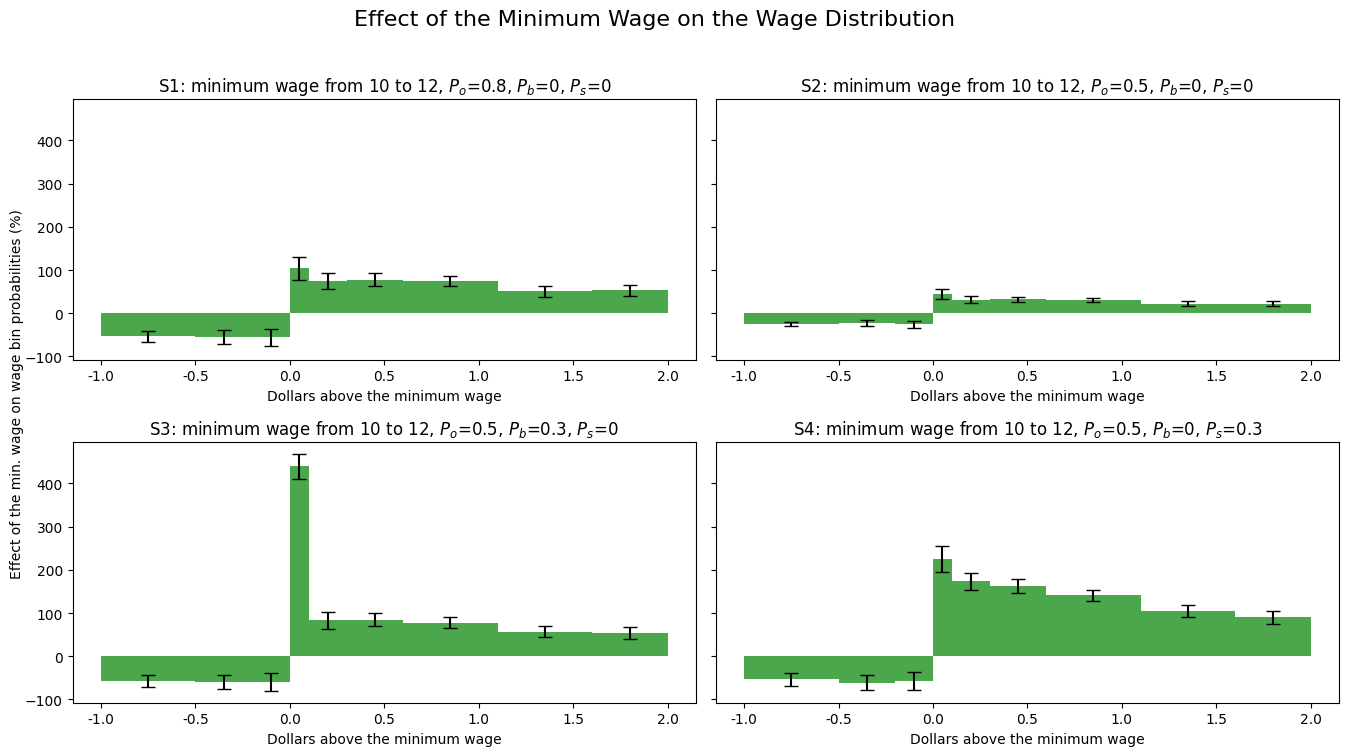

In [ ]:
x_values = []
x_labels = []
widths = []
for var in filtered_data['Variable']:
    if var in x_ranges:
        range_start, range_end = x_ranges[var]
        x_values.append(np.mean([range_start, range_end]) * 10)  # Convert to dollar
        x_labels.append(f"{range_start} to {range_end}")
        widths.append((range_end - range_start) * 10)  # Convert to dollar

# Define the figure and axes for subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharey=True)

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot each scenario in a separate subplot
for i, scenario in enumerate(scenarios):
    real_m_pre, real_m_post, P_o, P_b, P_s = scenarios[scenario]
    scenario_data = filtered_data[filtered_data['Scenario'] == scenario]
    x_scenario_values = [np.mean([x_ranges[var][0], x_ranges[var][1]]) for var in scenario_data['Variable']]  # Convert to percentage
    y_values = scenario_data['Coefficient'] * 100  # Convert to percentage
    y_err = scenario_data['SE'] * 100  # Convert to percentage
    scenario_widths = [(x_ranges[var][1] - x_ranges[var][0]) for var in scenario_data['Variable']]  # Convert to percentage
    
    # Plot the data
    axes[i].bar(x_scenario_values, y_values, width=scenario_widths, yerr=y_err, capsize=5, label=scenario, color = 'green', alpha = 0.7)
    axes[i].set_xlabel('Dollars above the minimum wage')
    axes[i].set_title(f'{scenario}: minimum wage from {real_m_pre} to {real_m_post}, $P_o$={P_o}, $P_b$={P_b}, $P_s$={P_s}')
    # set ylim
    # axes[i].set_ylim(-400, 400)
    # Set x-ticks with a break of 5 bins (0.5 dollars)
    axes[i].set_xticks(np.arange(-1.0, 2.1, .5))
    axes[i].set_xticklabels(np.arange(-1.0, 2.1, 0.5))

# Set common ylabel
fig.text(0.04, 0.5, 'Effect of the min. wage on wage bin probabilities (%)', va='center', rotation='vertical')

# Set the main title
plt.suptitle('Effect of the Minimum Wage on the Wage Distribution (OLS)', fontsize=16)

# Adjust layout
plt.tight_layout(rect=[0.04, 0.04, 1, 0.96])
plt.show()
